In [1]:
# %matplotlib qt
import rom_inverse as ri
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import sklearn.gaussian_process.kernels as kernels
from poisson_fem import PoissonFEM
import ROM
import numpy as np
import scipy as sp
import petsc4py
import sys
petsc4py.init(sys.argv)
from petsc4py import PETSc
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, HMC
import os
import pyro.contrib.gp as gp
smoke_test = ('CI' in os.environ)  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.2.1')
pyro.enable_validation(True)       # can help with debugging
import time
import Data
from CG_Surrogate import cg_surrogate

In [2]:
lin_dim_fom = 16                      # Linear number of rom elements

kernel = gp.kernels.RBF(input_dim=2, variance=torch.tensor(2.), lengthscale=torch.tensor([.3, .1]))
permeability_random_field = ri.DiscretizedRandomField(kernel=kernel, resolution=[lin_dim_fom],
                                                     nugget=1e-3)

In [3]:
a = torch.tensor([-1, 1, 2])               # Boundary condition function coefficients


# Define mesh and boundary conditions
mesh = PoissonFEM.RectangularMesh(torch.ones(lin_dim_fom)/lin_dim_fom)
# mesh.plot()

def origin(x):
    return torch.abs(x[0]) < torch.finfo(torch.float32).eps and torch.abs(x[1]) < torch.finfo(torch.float32).eps

def ess_boundary_fun(x):
    return 0.0
mesh.set_essential_boundary(origin, ess_boundary_fun)

def domain_boundary(x):
    # unit square
    return torch.abs(x[0]) < torch.finfo(torch.float32).eps or torch.abs(x[1]) < torch.finfo(torch.float32).eps or \
            torch.abs(x[0]) > 1.0 - torch.finfo(torch.float32).eps or torch.abs(x[1]) > 1.0 - torch.finfo(torch.float32).eps
mesh.set_natural_boundary(domain_boundary)

def flux(x):
    q = np.array([a[0] + a[2]*x[1], a[1] + a[2]*x[0]])
    return q

In [4]:
#Specify right hand side and stiffness matrix
rhs = PoissonFEM.RightHandSide(mesh)
rhs.set_natural_rhs(mesh, flux)
K = PoissonFEM.StiffnessMatrix(mesh)
rhs.set_rhs_stencil(mesh, K)

In [5]:
# define fom
fom = ROM.ROM(mesh, K, rhs, (lin_dim_fom + 1)**2)
# Change for non unit square domains!!
xx, yy = torch.meshgrid((torch.linspace(0, 1, lin_dim_fom + 1), torch.linspace(0, 1, lin_dim_fom + 1)))
X = torch.cat((xx.flatten().unsqueeze(1), yy.flatten().unsqueeze(1)), 1)
fom.mesh.get_interpolation_matrix(X)

In [6]:
fom_autograd = fom.get_autograd_fun()

In [7]:
beta = 50
permeability_random_field.set_covariance_matrix()
scale_tril = permeability_random_field.log_permeability_scale_tril.detach()
mu_zero = torch.zeros(permeability_random_field.X.shape[0])
def joint_posterior():
    x = pyro.sample('x', dist.MultivariateNormal(mu_zero, scale_tril=scale_tril))
    lambdaf = torch.exp(x)
    uf = fom_autograd(lambdaf)
    uf_observed = pyro.sample('uf_observed', dist.Normal(uf, torch.ones_like(uf)/beta))
    return uf_observed

In [8]:
print('x == ', x := permeability_random_field.sample_log_permeability())
print('uf_observed == ', uf_observed := fom_autograd(torch.exp(x)))

x ==  tensor([[-8.8639e-01, -6.5257e-02,  8.4889e-01,  1.6747e+00,  1.7035e+00,
          8.2363e-01,  7.1224e-01,  1.2125e+00,  1.0848e+00,  1.1532e+00,
          2.1646e+00,  2.2503e+00,  4.0315e-01, -1.5918e+00, -1.4287e+00,
          3.1141e-01, -1.0207e+00,  3.1795e-02,  1.1713e+00,  1.9009e+00,
          1.5685e+00,  7.6449e-01,  9.3545e-01,  1.5894e+00,  1.4376e+00,
          1.2430e+00,  1.7592e+00,  1.7065e+00, -7.6244e-02, -1.7451e+00,
         -1.2999e+00,  5.0678e-01, -9.7945e-01,  4.2859e-02,  1.3188e+00,
          1.9590e+00,  1.2748e+00,  6.1755e-01,  1.1159e+00,  2.0527e+00,
          1.8090e+00,  1.2489e+00,  1.3710e+00,  1.0434e+00, -5.1162e-01,
         -1.7162e+00, -1.1668e+00,  7.2133e-01, -1.0060e+00,  4.4693e-02,
          1.4024e+00,  1.8618e+00,  1.0511e+00,  4.2412e-01,  1.2936e+00,
          2.5473e+00,  2.1636e+00,  1.3698e+00,  1.1435e+00,  5.3190e-01,
         -8.2968e-01, -1.6682e+00, -8.1200e-01,  8.6390e-01, -8.4394e-01,
          2.8077e-02,  1.1957e+0

In [9]:
def conditioned_posterior(uf_observed):
    return pyro.condition(joint_posterior, data={"uf_observed": uf_observed})

In [10]:
nuts_kernel = NUTS(conditioned_posterior(uf_observed))
mcmc = MCMC(nuts_kernel, num_samples=400, warmup_steps=100, num_chains=1)
mcmc.run()
mcmc.summary()

Sample: 100%|██████████| 500/500 [06:10,  1.35it/s, step size=3.24e-02, acc. prob=0.744]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      x[0]     -0.90      0.18     -0.91     -1.18     -0.60    435.60      1.01
      x[1]     -0.02      0.29     -0.05     -0.48      0.44    573.74      1.00
      x[2]      1.20      0.30      1.20      0.76      1.71    515.50      1.00
      x[3]      1.86      0.36      1.86      1.31      2.40    361.02      1.00
      x[4]      1.58      0.41      1.59      0.92      2.24    274.90      1.00
      x[5]      1.06      0.40      1.04      0.39      1.63    447.81      1.00
      x[6]      1.01      0.35      1.01      0.48      1.57    504.04      1.00
      x[7]      1.19      0.28      1.18      0.73      1.64    429.13      1.00
      x[8]      1.12      0.29      1.10      0.66      1.59    500.40      1.00
      x[9]      1.24      0.29      1.25      0.80      1.71    474.52      1.00
     x[10]      1.98      0.24      1.98      1.59      2.34    481.89      1.00
     x[11]      2.09      0

In [11]:
fom.n_forward_calls

140083

In [12]:
fom.n_backward_calls

140077

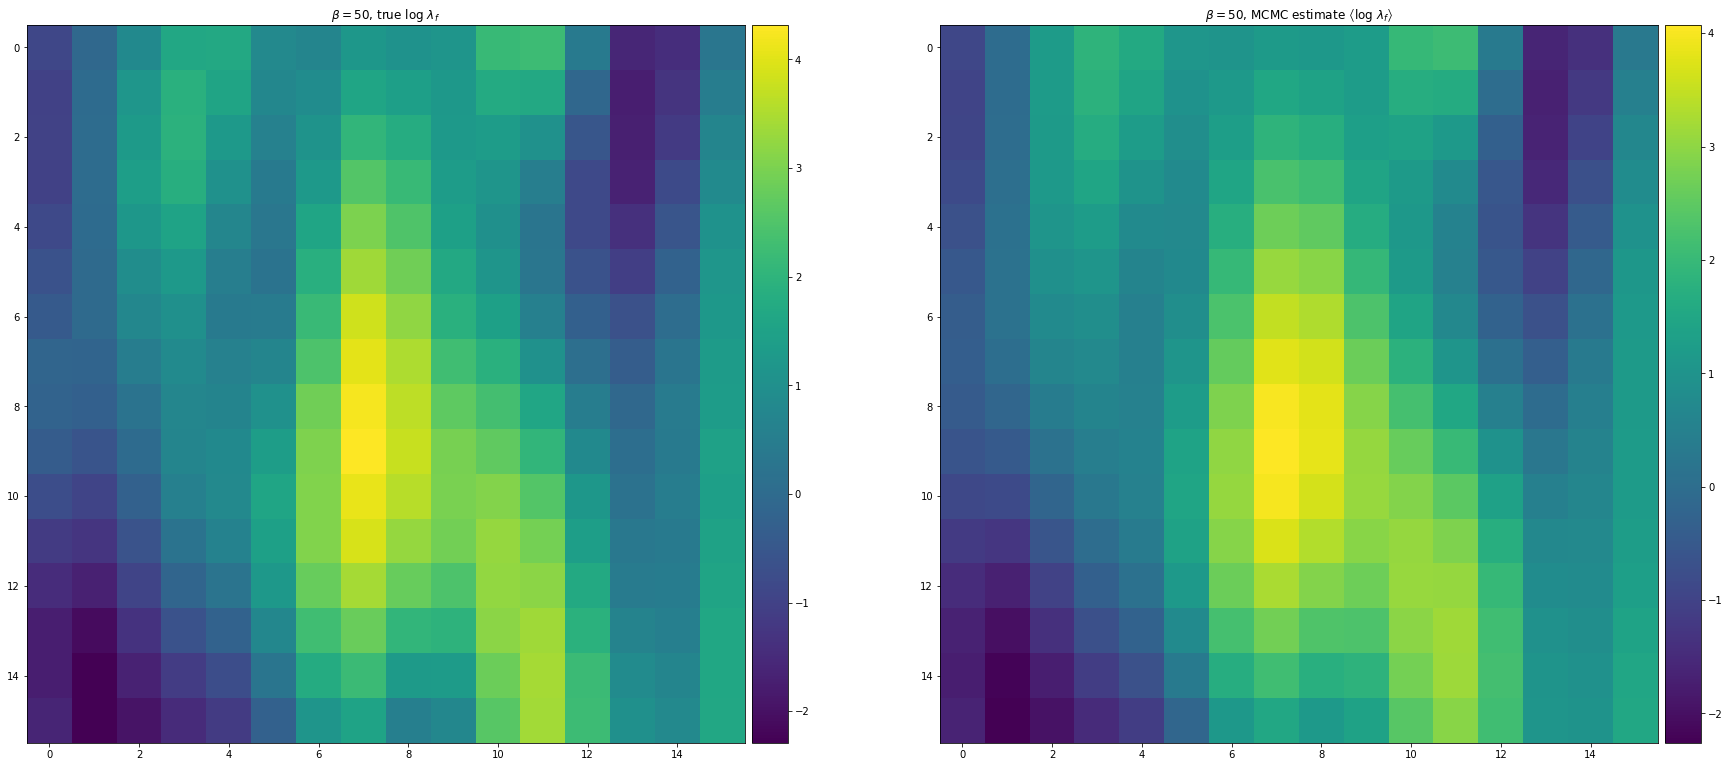

In [13]:
fig = plt.figure(figsize=(30, 20))
ax = plt.subplot(1, 2, 1)
plt.title(fr'$\beta = {beta}$, true $\log~ \lambda_f$')
im0 = ax.imshow(x[0].view(lin_dim_fom, lin_dim_fom))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im0, cax=cax)

ax = plt.subplot(1, 2, 2)
plt.title(fr'$\beta = {beta}$, MCMC estimate $\left<\log~ \lambda_f\right>$')
im1 = ax.imshow(torch.mean(mcmc.get_samples()['x'], 0).view(lin_dim_fom, lin_dim_fom))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im1, cax=cax)

In [14]:
fom.n_forward_calls = 0
fom.n_backward_calls = 0

In [15]:
hmc_kernel = HMC(conditioned_posterior(uf_observed), step_size=1e-4, num_steps=1, jit_compile=True)
mcmc = MCMC(hmc_kernel, num_samples=4000, warmup_steps=1000, num_chains=1)
mcmc.run()
mcmc.summary()

Warmup:   0%|          | 0/5000 [00:00, ?it/s]/home/constantin/cluster/python/projects/rom_inverse/ROM.py:128: TracerWarning: Converting a tensor to a NumPy array might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  lmbda = lmbda.detach().numpy()
/home/constantin/cluster/python/projects/rom_inverse/ROM.py:136: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  return torch.tensor(self.interpolated_solution.array, dtype=self.dtype)
Sample: 100%|██████████| 5000/5000 [00:12, 387.28it/s, step size=1.10e-01, acc. prob=0.918]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      x[0]      0.84      0.22      0.81      0.55      1.21      2.63      2.31
      x[1]     -0.25      0.15     -0.22     -0.49     -0.03      3.28      2.00
      x[2]      1.22      0.12      1.19      1.02      1.41      3.45      1.63
      x[3]      1.33      0.06      1.33      1.24      1.43      7.54      1.00
      x[4]      0.64      0.09      0.62      0.51      0.76      3.59      2.10
      x[5]      0.90      0.04      0.90      0.85      0.96     14.82      1.05
      x[6]      0.62      0.19      0.66      0.35      0.93      3.30      1.88
      x[7]      0.85      0.10      0.87      0.68      1.00      7.52      1.25
      x[8]      1.05      0.02      1.05      1.02      1.09      7.30      1.16
      x[9]      0.58      0.06      0.56      0.50      0.69      2.84      1.99
     x[10]      1.66      0.08      1.65      1.56      1.81      3.27      2.02
     x[11]      1.95      0

In [16]:
print('forward calls:   ', fom.n_forward_calls)
print('backward calls:  ', fom.n_backward_calls)

forward calls:    5072
backward calls:   5062


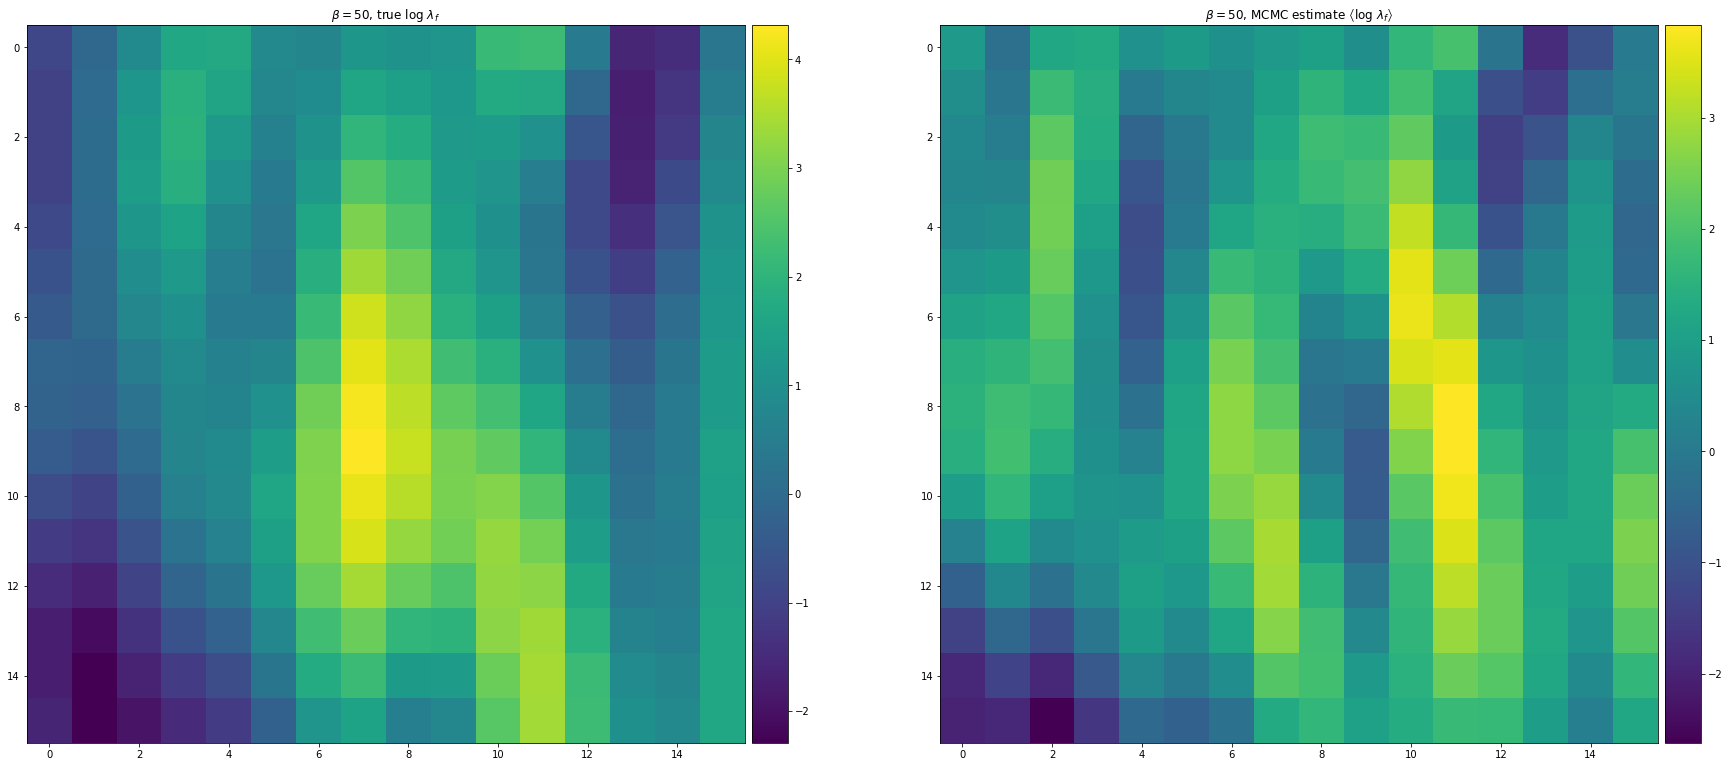

In [17]:
fig = plt.figure(figsize=(30, 20))
ax = plt.subplot(1, 2, 1)
plt.title(fr'$\beta = {beta}$, true $\log~ \lambda_f$')
im0 = ax.imshow(x[0].view(lin_dim_fom, lin_dim_fom))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im0, cax=cax)

ax = plt.subplot(1, 2, 2)
plt.title(fr'$\beta = {beta}$, MCMC estimate $\left<\log~ \lambda_f\right>$')
im1 = ax.imshow(torch.mean(mcmc.get_samples()['x'], 0).view(lin_dim_fom, lin_dim_fom))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im1, cax=cax)

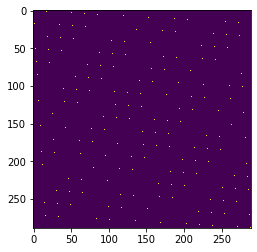

In [18]:
plt.imshow(fom.mesh.interpolation_matrix_torch)

In [19]:
plt.imshow(np.reshape(fom.full_solution.array, (33, 33)))

ValueError: cannot reshape array of size 289 into shape (33,33)

In [ ]:
plt.imshow(np.reshape(fom.interpolated_solution.array, (33, 33)))

In [ ]:
fom.mesh.interpolation_matrix_torch

In [ ]:
fom.interpolated_solution.array